In [43]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import utils as ut

# Model of the ant colony
system_name = 'ant_cons2_fast'
# Name of the specific run with the current parmeters
run_name = '2p_gamma_ev1'

data_dir = 'data/' + system_name + '/' + run_name + '/'

## Environment

### General parameters

In [27]:
env_params = dict()

# Size of the belly of each ant
env_params['max_k'] = 10
# Number of recipient in the colony
env_params['n_recipients'] = 1
# Probability of a succesfull gathering
env_params['p_succ'] = 0.1

if system_name == 'ant_cons' or system_name == 'ant_cons2' or system_name == 'ant_cons2_fast':
    # Probability that the food of a recipient decreases
    env_params['p_consume'] = 0.1

### Initial condition

In [28]:
# Number between 1-max_k for a deterministic initialization of the ant food
# Number greater than max_k for a random initialization
env_params['init_k'] = [env_params['max_k']+1 for _ in range(env_params['n_recipients']+1)]

## Algorithm

### Algorithm type

In [29]:
alg_params = dict()
alg_params['alg_type'] = 'nac'
alg_params['gamma'] = 0.995
alg_params['stop_by_discount'] = 'true'

# TIME
alg_params['n_steps'] = 2000000 # Number of training steps
alg_params['traj_points'] = 200

# EVALUATION
alg_params['eval_steps'] = 1000 # Number of evaluation steps at the end of the training

### General parameters

In [30]:
# CRITIC LEARNING RATE
alg_params['a0'] = 0.0005
alg_params['ac'] = alg_params['n_steps'] / 100
alg_params['a_expn'] = 0.8
alg_params['a_burn'] = alg_params['n_steps']/2

# ACTOR LEARNING RATE
alg_params['b0'] = 0.000001
alg_params['bc'] = alg_params['n_steps'] / 300
alg_params['b_expn'] = 0.8
alg_params['b_burn'] = alg_params['n_steps']

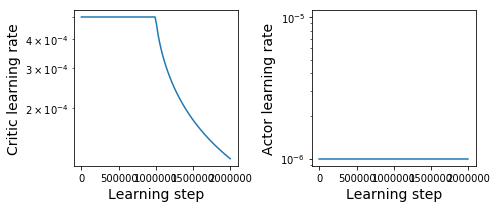

In [31]:
fig, (ax1, ax2) = ut.plot_lr(alg_params)
plt.tight_layout()

### Init condition of the learning

In [32]:
# INITIAL CONDITIONS
# Comment 'init_q_path' for a flat policy
alg_params['init_values'] = 15
#alg_params['init_values_rand'] = 150

In [33]:
#alg_params['init_val_path'] = data_dir + '/init_val.txt' 
#forag_val = 25
#rec_val = forag_val
#vals = np.ones((env_params['n_recipients']+1, 2*(1+env_params['max_k'])))*rec_val
#vals[0]*=forag_val/rec_val
#np.savetxt(data_dir + '/init_val.txt', vals, delimiter='\t')

## Wtriting the parameters in data_dir

In [34]:
ut.write_params(env_params, data_dir, "param_env.txt")
ut.write_params(alg_params, data_dir, "param_alg.txt")

## Set init policy

In [35]:
def policy_1_above(k):
    pol = []
    for i in range((env_params['max_k']+1)*2):
        if i<env_params['max_k']+1:
            if i<=k:
                pol.append([1,0])
            else:
                pol.append([0,1])
        else:
            pol.append([1])
    return pol

def rand_policy():
    pol = []
    for i in range((env_params['max_k']+1)*2):
        if i<env_params['max_k']+1:
            pol.append([0.5,0.5])
        else:
            pol.append([1])
    return pol

In [62]:
policies = []
for_pol = []
# Forager
policies.append(policy_1_above(9))
#policies.append(rand_policy())

# Recipients
for p in range(env_params['n_recipients']):
    policies.append(policy_1_above(8))

### Writing external files

In [63]:
for p in range(env_params['n_recipients']+1):
    f = open(data_dir+'init_pol'+str(p)+'.txt', "w")
    for l in policies[p]:
        s = ''
        for elem in l:
            s+=str(elem)
            s+='\t'
        f.write(s+'\n')
    f.close()

In [64]:
alg_params['init_pol_dir'] = data_dir
#alg_params['init_pol_dir'] = 'data/' + system_name + '/2p_long_gamma1/' 
ut.write_params(env_params, data_dir, "param_env.txt")
ut.write_params(alg_params, data_dir, "param_alg.txt")